In [323]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import confusion_matrix
import numpy as np
import openpyxl.workbook
import psycopg2
import itertools
import json
import csv
import sys
import pickle
from scipy import stats
from copy import deepcopy
import seaborn as sns
import math 

from sklearn.model_selection import KFold
from sklearn.tree._tree import TREE_LEAF, TREE_UNDEFINED
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

params = { 'figure.figsize': (15, 5),
         'font.size': 15}
plt.rcParams.update(params)
courses_codes = pd.read_excel ('data/courses_codes.xlsx').fillna(value=0)

In [15]:
# Load data
path = 'data/agregados_semestre.csv'
original = pd.read_csv(path, sep =',')
original['quantidade'] = 1
original.dropna(how='any', inplace=True)
original.head()

# Load Features
tree_features = pd.read_csv('data/features.csv', sep =',')
labels = []
with open('data/labels.csv', 'rb') as inputfile:
    for row in csv.reader(inputfile):
        labels.append(row[0])

In [364]:
# ### Pesos baseados na contribuição de cada menção para o IRA
# NC = 2.5 # Peso para alunos que não cursaram a disciplina
# grades_dict = {
#     'SS': 5,
#     'MS': 4,
#     'MM': 3,
#     'CC': 2.5,
#     'TR': 2,
#     'MI': 2,
#     'II': 1,
#     'SR': 0,
#     'TJ': 2.5
# }

### Pesos baseados na nota correspondente a cada menção
# NC = 4 # Peso para alunos que não cursaram a disciplina
# grades_dict = {
#     'SS': 9,
#     'MS': 7,
#     'MM': 5,
#     'CC': 5,
#     'TR': 4,
#     'MI': 3,
#     'II': 1,
#     'SR': 0,
#     'TJ': 4
# }

### Pesos centrados na origem
NC = 0 # Peso para alunos que não cursaram a disciplina
grades_dict = {
    'SS': 3,
    'MS': 2,
    'MM': 1,
    'MI': -1,
    'II': -2,
    'SR': -3,
    'CC': 2,
    'TR': -0.5,
    'TJ': 0
}

### Binario - reprovou ou não
# NC = 0 # Peso para alunos que não cursaram a disciplina
# grades_dict = {
#     'SS': 1,
#     'MS': 1,
#     'MM': 1,
#     'MI': -2,
#     'II': -2,
#     'SR': -2,
#     'CC': 1,
#     'TR': -1,
#     'TJ': 0
# }

grades = []

for grade in original['mencao']:
    grades.append(grades_dict[grade])

original['peso'] = grades
original.head()

,id,id_aluno,ano_ingresso,semestre_ingresso,cod_disciplina,mencao,ano_referencia,semestre_referencia,periodo_cursou_disciplina,id_tabela_ingresso,Status,quantidade,peso
0,0,aluno88,2008,2,113093,SR,2009,2,2,1,Formatura,1,-3.0
1,1,aluno88,2008,2,118001,MI,2009,2,2,1,Formatura,1,-1.0
2,2,aluno88,2008,2,118001,SR,2009,2,2,1,Formatura,1,-3.0
3,3,aluno88,2008,2,113034,II,2010,1,3,1,Formatura,1,-2.0
4,4,aluno88,2008,2,118001,MI,2013,2,10,1,Formatura,1,-1.0


In [17]:
##################### EXTRACT FEATURES #####################

def make_features(courses_codes):
    
    colunas_novo = []
    colunas_novo.append('id')
    colunas_novo.append('status')

    for i in courses_codes['Codigo'].unique():
        colunas_novo.append(i)

    tree_features = pd.DataFrame(columns = colunas_novo)
    active_students = pd.DataFrame(columns = colunas_novo)
    transferred_students = []

    student_ids = original['id_aluno'].unique()   
    codes = courses_codes.iloc[:,0].values
    
    for student_id in student_ids:
        student = original[original['id_aluno'] == student_id]
        this_student = np.zeros(tree_features.columns.size, dtype=object)
        for semester in range(1,3):
            this_semester = student[(student['periodo_cursou_disciplina'] == semester)]
            for course in codes:
                this_student_ref=sum(this_semester[this_semester['cod_disciplina'] == course]['peso'])
                course_ref = original[original['cod_disciplina'] == course]
                year_ref = student[(student['periodo_cursou_disciplina'] == semester)]['ano_referencia'].unique()
                semester_ref = student[(student['periodo_cursou_disciplina'] == semester)]['semestre_referencia'].unique()            
                students_ref = course_ref[(course_ref['ano_referencia'].isin(year_ref)) & course_ref['semestre_referencia'].isin(semester_ref)]
                mean_ref = sum(students_ref['peso']/len(students_ref))
            
                index = np.where(course == codes)[0][0] + 2
#                 this_student[index] += this_student_ref * 2 - mean_ref #For normalizing
                this_student[index] += this_student_ref

                
        this_student[0] = student_id
        this_student[1] = student['Status'].unique()[0]

        if(this_student[1] == 'Ativo'):
            active_students.loc[len(active_students)] = this_student
        elif (this_student[1] != 'Falecimento'):
            tree_features.loc[len(tree_features)] = this_student

    return (tree_features, active_students)

def make_labels(semester, courses_codes):
    labels=[]
    for i in courses_codes['Nome']:
        labels.append(i)
    return labels


# #################### Make Features #####################
# courses_codes = pd.read_csv('data/semestre2.csv', sep =',')

# tree_features, active_students = make_features(courses_codes)
# tree_labels = make_labels(2, courses_codes)

# #################### Find best training set ####################
# # rstate = find_best_training(tree_features)

# # #################### Save Features #####################
# export_features = tree_features.to_csv ('data/features.csv', index = None, header=True)
# result_file = open('data/labels.csv','w')
# for label in tree_labels:
#     result_file.write(label + "\n")
# result_file.close()

# print("done")

In [18]:
##################### REMOVE OUTLIERS #####################

def get_features(tree_features, remove_outliers=False, plot = False):
    X = tree_features.drop(['id', 'status'], axis=1) # Features
    y = tree_features.status # Target variable
    
    if(remove_outliers):
        z = np.abs(stats.zscore(X))
        X = X[(z < 3).all(axis=1)]
        y = y[(z < 3).all(axis=1)]
        new_tree_features = tree_features[(z < 3).all(axis=1)]

        if(plot):
            fig = plt.figure(figsize=(15,600),facecolor='w') 

            size = int((len(tree_features)+1)/2)
            for i in range(2,len(tree_features.columns)):
                plt.subplot(size, 2, i-1)
                sns.boxplot(x=tree_features[tree_features.columns[i]], y=tree_features['status']).set_title('')        
        
    return X, y

# get_features(tree_features, True, True);

In [19]:
##################### PLOTS #####################

def generate_img(clf, img_name, feature_labels, tree_features):
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True, feature_names = feature_labels,class_names=tree_features['status'].unique())
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(img_name)
    Image(graph.create_png())

def plot_confusion_matrix(cm, classes, subplot_index, title, total):
    
    normalize=True
    cmap=plt.cm.Blues

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax = fig.add_subplot(total,1,subplot_index)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [20]:
##################### K-FOLD CROSS CORRELATION #####################

def cross_corr(tree_features):
            
    X = tree_features.drop(['id', 'status'], axis=1) # Features
    y = tree_features.status # Target variable
                
    kf = KFold(n_splits=5, random_state = 0)
    kf.get_n_splits(X)
    result = []
    conf_matrix = [[0, 0],[0, 0]]

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        clf = DecisionTreeClassifier(random_state=1)
        clf = clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        conf_matrix += confusion_matrix(y_test, y_pred, tree_features['status'].unique())
        accuracy = metrics.accuracy_score(y_test, y_pred)
        result.append(accuracy)

    mean = sum(result)/len(result)
    conf_matrix = conf_matrix/5
    print(result)
    print(conf_matrix)
    print(mean)

    return result, conf_matrix

In [21]:
##################### SAVE TREE #####################

def save_tree(filename, clf):
    decision_tree_model_pkl = open(filename, 'wb')
    pickle.dump(clf, decision_tree_model_pkl)
    decision_tree_model_pkl.close()
    
def load_tree(filename):
    decision_tree_model_pkl = open(filename, 'rb')
    return pickle.load(decision_tree_model_pkl)

In [177]:
###################### FIND THE ALPHAS FOR COST-COMPLEXITY PRUNING ######################

def convert_labels(y, direction):
    if(direction):
        y[y=='Formatura'] = 1
        y[y=='Evadiu'] = 0 
    else:
        y[y==1] = 'Formatura'
        y[y==0] = 'Evadiu'
    return y

def find_subtree(tree, node_index):
    minus_counter = 0
    required_minus = 2
    index = node_index + 1
    while minus_counter != required_minus:
        if(index >= len(tree)-1):
            break
        if(tree[index] == TREE_LEAF):
            minus_counter += 1
        elif(tree[index] == TREE_UNDEFINED):
            index += 1
        else:
            required_minus += 1
        index += 1
        
    return index

def get_error_node(tree, node_index):
    n_samples = sum(tree.value[0][0])
    brother_index = find_subtree(tree.children_left, node_index)
    
    leaves = np.where(tree.children_left[node_index:brother_index] == TREE_LEAF)[0]
    node_error = tree.value[node_index].min()/n_samples
    leaves_error = sum(tree.value[node_index + index].min() for index in leaves)/n_samples
    
    g = (node_error - leaves_error)/(len(leaves) - 1)
    return node_index, node_error, g, leaves_error, brother_index, len(leaves)

def cost_complexity(tree, tree_nodes, X_test, y_test):
    min_g = tree_nodes[tree_nodes['g'] == min(tree_nodes['g'])]
    nodes_to_prune = min_g[min_g['n_leaves'] == max(min_g['n_leaves'])]
    for index, node in nodes_to_prune.iterrows():
        tree.tree_.children_left[int(node['node_index'])] = TREE_LEAF
        for leaves in range (int(node['node_index'] + 1), int(node['brother_index'])):
            tree.tree_.children_left[leaves] = TREE_UNDEFINED
    
    y_pred = clf.predict(X_test)
    error = metrics.mean_absolute_error(convert_labels(y_test, True), convert_labels(y_pred, True))
    accuracy = metrics.accuracy_score(convert_labels(y_test, False), convert_labels(y_pred, False))    
    n_leaves = len(tree.tree_.children_left[tree.tree_.children_left == TREE_LEAF])
    alpha = min(tree_nodes['g'])
    
    return alpha, n_leaves, accuracy, error
    
def find_alphas(tree, X_test, y_test):
    result = pd.DataFrame(columns = ['alpha', 'n_leaves', 'accuracy', 'error'])
    current_n = len(tree.tree_.children_left[tree.tree_.children_left == TREE_UNDEFINED])
    total_n = len(tree.tree_.children_left)
    trees = []
    
    while(total_n - current_n > 2):
        tree_nodes = pd.DataFrame(columns = ['node_index', 'node_error', 'g', 'leaves_error', 'brother_index', 'n_leaves'])

        nodes = tree.tree_.children_left[(tree.tree_.children_left != TREE_LEAF) & (tree.tree_.children_left != TREE_UNDEFINED)] - 1
        for node in nodes:    
            tree_nodes.loc[len(tree_nodes)] = get_error_node(tree.tree_, node)
                    
        cost = cost_complexity(tree, tree_nodes, X_test, y_test)
        idx = result.index[result['alpha'] == cost[0]].tolist()
        tree_size = len(tree.tree_.children_left[(tree.tree_.children_left != TREE_UNDEFINED) & (tree.tree_.children_left != TREE_LEAF) ])

        if(tree_size > 1):
            if (idx):
                replace_tree = deepcopy(tree)
                result.loc[idx[0]] = cost
                trees[idx[0]] = replace_tree
            else:
                result.loc[len(result)] = cost
                trees.append(deepcopy(tree))

        current_n = len(tree.tree_.children_left[tree.tree_.children_left == TREE_UNDEFINED])
        
    return result, trees

def cost_complexity_pruning(tree, node_index, alpha):
    n_samples = sum(tree.tree_.value[0][0])
    brother_index = find_subtree(tree.tree_.children_left, node_index)
    
    new_tree = deepcopy(tree)
    new_tree.tree_.children_left[node_index+1:brother_index] = TREE_UNDEFINED
    new_tree.tree_.children_left[node_index] = TREE_LEAF
    
    new_leaves = np.where(new_tree.tree_.children_left == TREE_LEAF)[0]    
    new_tree_values = new_tree.tree_.value[new_tree.tree_.children_left == TREE_LEAF]
    new_error = sum(np.amin(new_tree_values[:,0,:], axis=1))

    new_error = new_error/n_samples
    new_L = len(new_leaves) if len(new_leaves) !=2 else 1
    new_cost = new_error + alpha * new_L
        
    return new_cost

def prune_node(tree, node_index):
    brother_index = find_subtree(tree.tree_.children_left, node_index)
    tree.tree_.children_left[node_index+1:brother_index] = TREE_UNDEFINED
    tree.tree_.children_left[node_index] = TREE_LEAF
    return tree
        
def prune(tree, alpha):
    nodes = tree.tree_.children_left[(tree.tree_.children_left != TREE_LEAF) & (tree.tree_.children_left != TREE_UNDEFINED)] - 1
    costs = []
    for node in nodes:  
        costs.append(cost_complexity_pruning(tree, node, alpha))
   
    node_to_prune = nodes[costs.index(min(costs))]
    return prune_node(tree, node_to_prune)

15

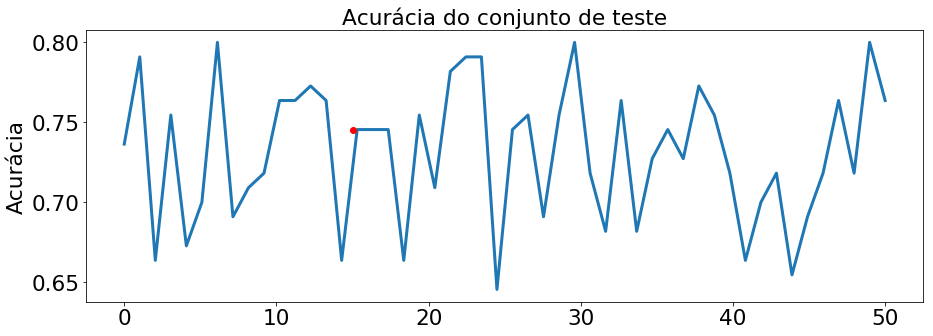

In [369]:
############## POST PRUNING ###############
split_range = 50

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_best_alpha(tree_features, alphas):

    X, y = get_features(tree_features)
    accuracy = pd.DataFrame(columns = alphas)
    accuracy['before_prune'] = None
    rstates=[]

    for i in tqdm_notebook(range(split_range), desc='1st loop'):
        this_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i, test_size=0.3)
        clf = DecisionTreeClassifier(random_state=0)
        clf = clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        accuracy_before_prune = metrics.accuracy_score(y_test, y_pred)
        
        for alpha in alphas:
            new_clf = deepcopy(clf)
            new_clf = prune(new_clf, alpha)
            y_pred = new_clf.predict(X_test)
            this_accuracy.append(metrics.accuracy_score(convert_labels(y_test, False), convert_labels(y_pred, False)))
        
        this_accuracy.append(accuracy_before_prune)
        accuracy.loc[len(accuracy)] = this_accuracy
        
    return accuracy

def compare_prune(tree_features, alpha):
    test_accuracy = []
    pruned_accuracy = []
    X, y = get_features(tree_features, True)

    conf_matrix = [[0, 0],[0, 0]]
    conf_matrix_pruned = [[0, 0],[0, 0]]

    for i in range(0, split_range):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i, test_size=0.3)
        clf = DecisionTreeClassifier(random_state=0)
        clf = clf.fit(X_train,y_train)
        
        # Predict before prune
        y_pred = clf.predict(X_test)
        conf_matrix += confusion_matrix(convert_labels(y_test, False), convert_labels(y_pred, False), tree_features['status'].unique())
        
        # Predict after prune
        new_clf = deepcopy(clf)
        new_clf = prune(new_clf, alpha)
        y_pred_new = new_clf.predict(X_test)
        conf_matrix_pruned += confusion_matrix(convert_labels(y_test, False), convert_labels(y_pred_new, False), tree_features['status'].unique())

        test_accuracy.append(metrics.accuracy_score(y_test, y_pred))
        pruned_accuracy.append(metrics.accuracy_score(y_test, y_pred_new))
        
    conf_matrix = conf_matrix / split_range
    conf_matrix_pruned = conf_matrix_pruned / split_range
            
    return conf_matrix, conf_matrix_pruned, test_accuracy, pruned_accuracy      


def find_median_rstate(tree_features, plot=False):
    test_accuracy = []
    pruned_accuracy = []
    X, y = get_features(tree_features, True)

    conf_matrix = [[0, 0],[0, 0]]
    conf_matrix_pruned = [[0, 0],[0, 0]]

    for i in range(0, split_range):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i, test_size=0.3)
        clf = DecisionTreeClassifier(random_state=0)
        clf = clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        test_accuracy.append(metrics.accuracy_score(y_test, y_pred))
        
    median_rstate = find_nearest(test_accuracy, np.median(test_accuracy))
        
    if(plot):
        fig = plt.figure(figsize=(15,5),facecolor='w') 
        plt.plot(np.linspace(0, split_range), test_accuracy, linewidth=3)
        plt.plot(median_rstate, test_accuracy[median_rstate], 'ro')
        plt.title(u'Acurácia do conjunto de teste')
        plt.ylabel(u'Acurácia')
    
    return median_rstate

def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() <= threshold:
    # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are children, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

find_median_rstate(tree_features, True)

In [360]:
###################### RUN ######################

# Load Tree - Used for tcc document
# clf = load_tree('tcc_doc.pkl')

X, y = get_features(tree_features, True)
rstate = find_median_rstate(tree_features) # Find median rstate of splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rstate, test_size=0.3)
clf = DecisionTreeClassifier() # Grow unpruned tree
clf = clf.fit(X_train, y_train)

# Find the alphas for cost-complexity pruning
result, trees = find_alphas(clf, X_test, y_test)
alphas = result['alpha'].unique()

# Find the best alpha
accuracy = find_best_alpha(tree_features, alphas)
result.head()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dScxc3QgbG9vcCcsIG1heD01MCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWR0aD11J2nigKY=


,alpha,n_leaves,accuracy,error
0,0.000000,66.0,0.790909,0.209091
1,0.001312,57.0,0.818182,0.181818
2,0.001575,52.0,0.809091,0.190909
3,0.001969,40.0,0.790909,0.209091
4,0.002625,37.0,0.790909,0.209091


[1, 6, 4, 1, 1, 1, 9, 1, 1]


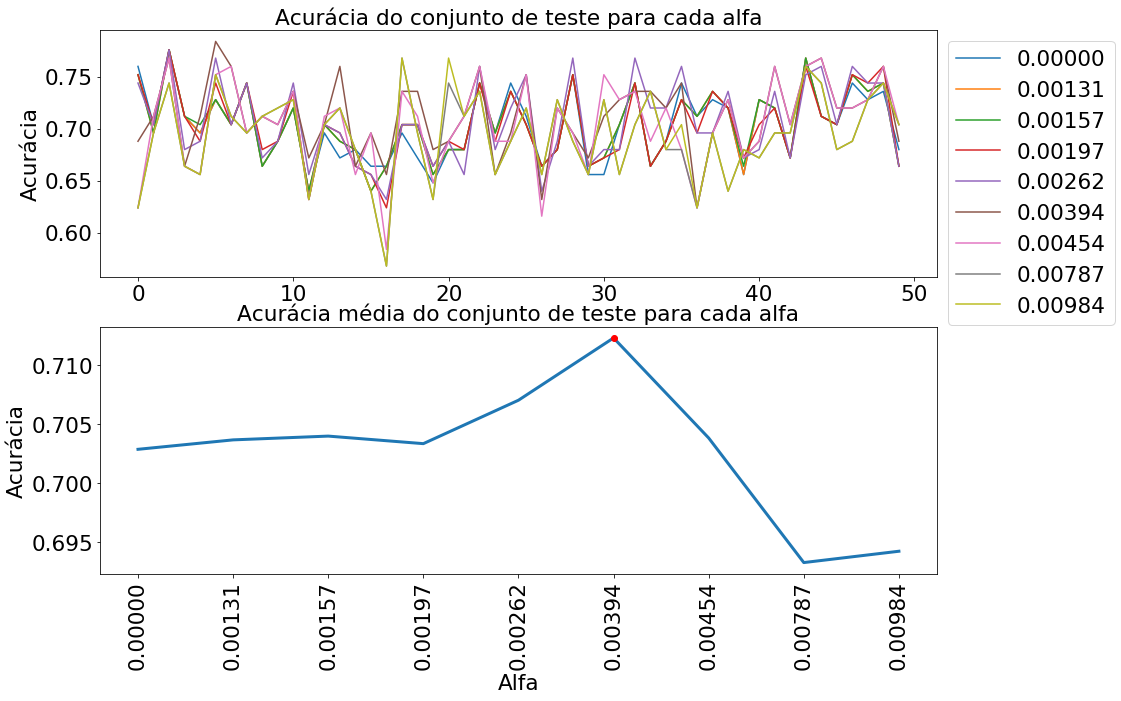

In [367]:
###################### CHOOSING ALPHA ######################

fig = plt.figure(figsize=(15,10),facecolor='w') 
params = { 'font.size': 10}

plt.subplot(211)
median_rstate = []
legends = []
for column in accuracy.columns[:-1]:
    median_rstate.append(find_nearest(accuracy[column], np.mean(accuracy[column])))
    plt.plot(accuracy[column])

for value in accuracy.columns.values[:-1]:
    legends.append(format(float(value), '.5f'))

plt.legend(legends, bbox_to_anchor=(1, 1))
plt.title(u'Acurácia do conjunto de teste para cada alfa')
plt.ylabel(u'Acurácia')
# plt.xlabel(u'Conjunto de teste avaliado')

print(median_rstate)
mean = []
for alpha in accuracy.columns[:-1]:
    mean.append(sum(accuracy[alpha])/len(accuracy[alpha]))
plt.subplot(212)
plt.plot(legends, mean, linewidth=3)
plt.plot(mean.index(max(mean)), max(mean), 'ro')
plt.title(u'Acurácia média do conjunto de teste para cada alfa')
plt.ylabel(u'Acurácia')
plt.xlabel(u'Alfa')
plt.xticks(rotation=90)
params = { 'font.size': 15}

In [371]:
###################### CHECK ALPHA FOR 50 SPLITS ######################
# total = len(trees)
# fig = plt.figure(figsize=(15,4*total),facecolor='w') 

# for index in range (0, total):
#     alpha = accuracy.columns[index]
#     conf_matrix, conf_matrix_pruned, test_accuracy, pruned_accuracy = compare_prune(tree_features, alpha)
# #     generate_img(tree, 'images/' + str(index) + '.png', labels, tree_features)    
#     plot_confusion_matrix(conf_matrix_pruned, tree_features['status'].unique(), index + 1, index, total+1)

# plot_confusion_matrix(conf_matrix, tree_features['status'].unique(), index + 2, 'before_prune', total+1)

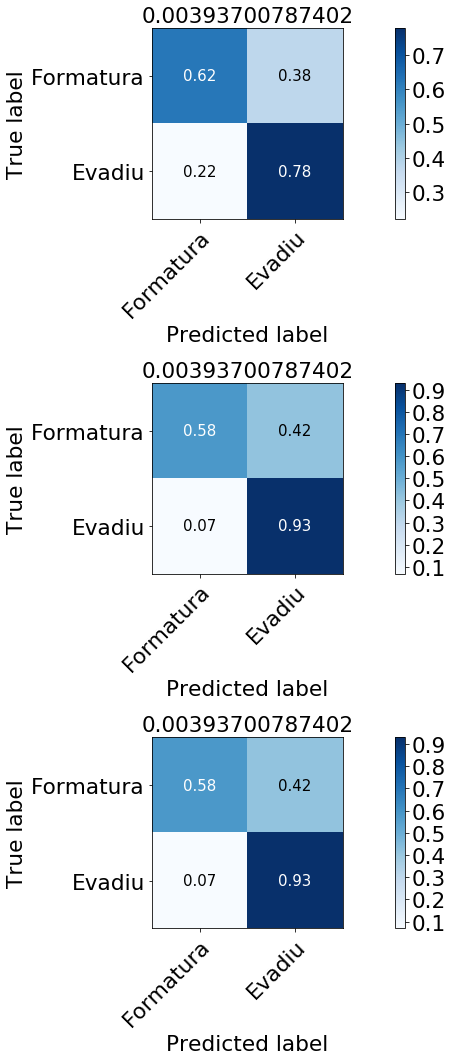

In [376]:
###################### CONFUSION MATRIX OF MEDIAN RSTATE ######################

fig = plt.figure(figsize=(15,15),facecolor='w') 
idx = mean.index(max(mean))
alpha = accuracy.columns[idx]
rstate = median_rstate[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
conf_matrix = confusion_matrix(convert_labels(y_test, False), convert_labels(y_pred, False), tree_features['status'].unique())
plot_confusion_matrix(conf_matrix, tree_features['status'].unique(), 1, alpha, 3);

# Predict after prune
new_clf = deepcopy(clf)
new_clf = prune(new_clf, alpha)
# new_clf = trees[idx]
new_y_pred = new_clf.predict(X_test)
new_conf_matrix = confusion_matrix(convert_labels(y_test, False), convert_labels(new_y_pred, False), tree_features['status'].unique())

plot_confusion_matrix(new_conf_matrix, tree_features['status'].unique(), 2, alpha, 3);

# Predict after 2nd prune
new_clf2 = deepcopy(new_clf)
prune_index(new_clf2.tree_, 0, 2)
new_y_pred2 = new_clf2.predict(X_test)
new_conf_matrix2 = confusion_matrix(convert_labels(y_test, False), convert_labels(new_y_pred2, False), tree_features['status'].unique())

plot_confusion_matrix(new_conf_matrix2, tree_features['status'].unique(), 3, alpha, 3);

In [355]:
###################### SAVE IMAGES BEFORE AND AFTER PRUNE ######################

# generate_img(clf, 'images/before_prune.png', labels, tree_features)    
# generate_img(new_clf, 'images/after_prune.png', labels, tree_features)    
# generate_img(new_clf2, 'images/after_prune2.png', labels, tree_features) 

0.71232
